In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.5 MB/s eta 0:00:00


train_imgs shape: (2459, 224, 224, 3)
test_imgs shape: (769, 224, 224, 3)
val_imgs shape: (615, 224, 224, 3)


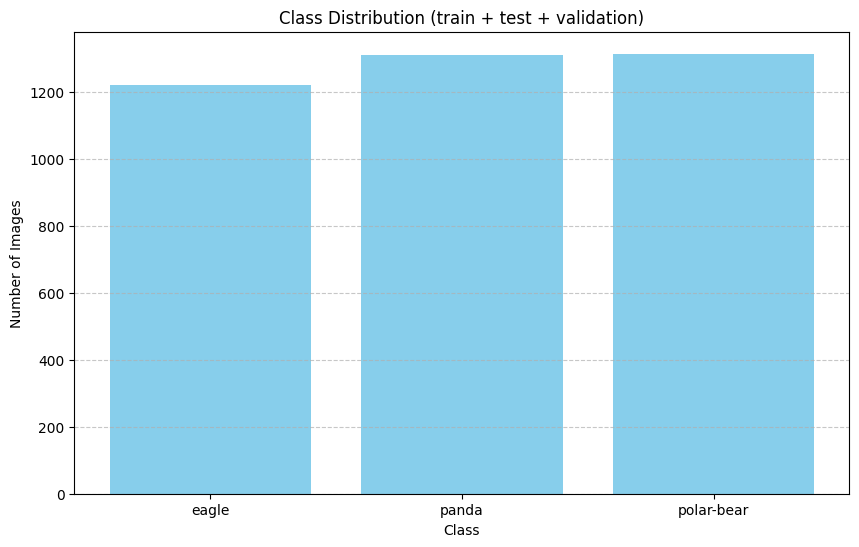

Broj slika po klasama pre oversamplinga:
eagle: 781 slika
panda: 837 slika
polar-bear: 841 slika
Oversampled train_imgs shape: (2509, 224, 224, 3)
Oversampled train_labels shape: (2509,)
Broj slika po klasama posle oversamplinga:
eagle: 831 slika
panda: 837 slika
polar-bear: 841 slika


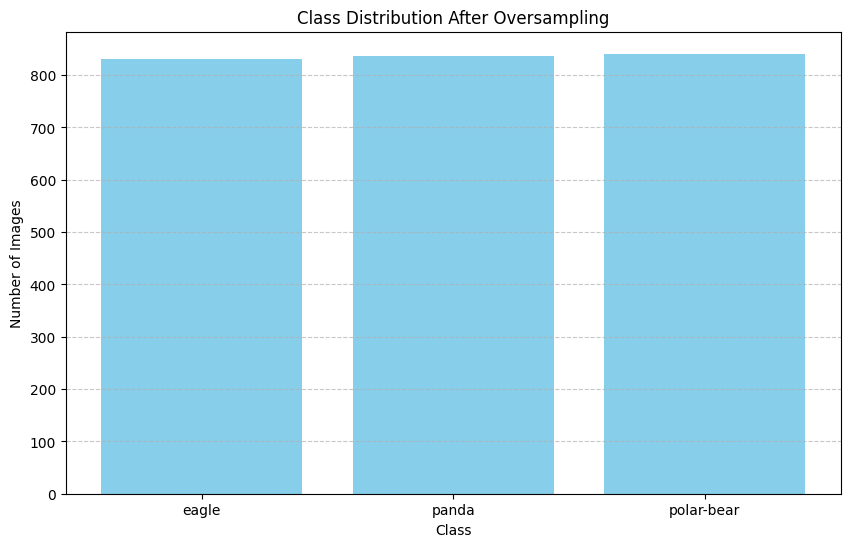

In [5]:
import argparse
import numpy as np
import pandas as pd
import cv2
import os
import tensorflow as tf
from tensorflow import keras
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import load_model, Model
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from kerastuner.tuners import RandomSearch
from imblearn.over_sampling import RandomOverSampler

# Mapiranje klasa
class_map = {'eagle': 0, 'panda': 1, 'polar-bear': 2}
reverse_class_map = {v: k for k, v in class_map.items()}  # Za obrnuto mapiranje brojeva nazad u nazive klasa

# Učitavanje slika i oznaka
train_imgs = np.load('drive/MyDrive/cropped/train_imgs.npy')
train_labels = np.load('drive/MyDrive/cropped/train_labels.npy')
test_imgs = np.load('drive/MyDrive/cropped/test_imgs.npy')
test_labels = np.load('drive/MyDrive/cropped/test_labels.npy')
val_imgs = np.load('drive/MyDrive/cropped/val_imgs.npy')
val_labels = np.load('drive/MyDrive/cropped/val_labels.npy')

def plot_class_distribution(labels, title):
    class_counts = np.bincount(labels)
    classes = [key for key, value in class_map.items()]
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(class_counts)), class_counts, tick_label=classes, color='skyblue')
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Prikaz oblika slika
print(f"train_imgs shape: {train_imgs.shape}")
print(f"test_imgs shape: {test_imgs.shape}")
print(f"val_imgs shape: {val_imgs.shape}")

#Prikaz distribucije klasa
all_labels = np.concatenate([train_labels, test_labels, val_labels])
plot_class_distribution(all_labels, 'Class Distribution (train + test + validation)')
# Prikaz broja slika po klasama pre oversamplinga
print("Broj slika po klasama pre oversamplinga:")
counts = np.bincount(train_labels)
for i, count in enumerate(counts):
    print(f"{reverse_class_map[i]}: {count} slika")

# Oversampling klase "eagle" (labela = 0)
ros = RandomOverSampler(sampling_strategy={0: len(train_labels[train_labels == 0]) + 50}, random_state=42)

train_imgs_reshaped = train_imgs.reshape(len(train_imgs), -1)

oversampled_imgs, oversampled_labels = ros.fit_resample(train_imgs_reshaped, train_labels)

oversampled_imgs = oversampled_imgs.reshape(-1, 224, 224, 3)

# Prikaz novih dimenzija skupa podataka
print(f"Oversampled train_imgs shape: {oversampled_imgs.shape}")
print(f"Oversampled train_labels shape: {oversampled_labels.shape}")

# Prikaz broja slika po klasama posle oversamplinga
print("Broj slika po klasama posle oversamplinga:")
oversampled_counts = np.bincount(oversampled_labels)
for i, count in enumerate(oversampled_counts):
    print(f"{reverse_class_map[i]}: {count} slika")

plot_class_distribution(oversampled_labels, 'Class Distribution After Oversampling')

# Augmentacija slika
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
)

# Kreiranje skupa podataka sa oversamplovanim slikama
train_set = train_datagen.flow(
    oversampled_imgs,
    oversampled_labels,
    batch_size=32,
    shuffle=True
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
)

val_set = val_datagen.flow(
    val_imgs,
    val_labels,
    batch_size=32,
    shuffle=False
)


In [ ]:
import argparse
import numpy as np
import pandas as pd
import cv2
import os
import tensorflow as tf
from tensorflow import keras
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.python.keras import layers, Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.python.keras.models import load_model, Model
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import kerastuner as kt
from kerastuner.tuners import RandomSearch

#Pomocne metode
def report_model(md, model_name, images, labels, classes):
    print("**********REPORT FOR ", model_name.upper(), " MODEL********** /n")
    predictions = md.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    report = classification_report(labels, predicted_labels, target_names=list(classes.keys()),
                                   labels=list(classes.values()))
    print(report)
    print("******************************************")

def build_model(hp):
    base_model = keras.applications.InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3),
        pooling='avg'
    )

    num_frozen_layers = hp.Int('num_frozen_layers', min_value=50, max_value=310, step=10)


    for layer in base_model.layers[:num_frozen_layers]:
        layer.trainable = False
    for layer in base_model.layers[num_frozen_layers:]:
        layer.trainable = True

    x = base_model.output
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(hp.Int('units', min_value=700, max_value=2048, step=200), activation='relu')(x)
    if hp.Boolean("dropout"):
        x = keras.layers.Dropout(hp.Float('dropout_rate', min_value=0.07, max_value=0.3, step=0.1))(x)

    predictions = keras.layers.Dense(3, activation='softmax')(x)

    model = keras.models.Model(inputs=base_model.input, outputs=predictions)

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Float('lr', min_value=1e-4, max_value=1e-2, sampling='log')),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model






87910968/87910968 [==============================] - 5s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activatio

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 3s 137ms/step - loss: 0.0397 - accuracy: 0.9883
Test Loss: 0.03969119116663933
Test Accuracy: 0.9882965087890625


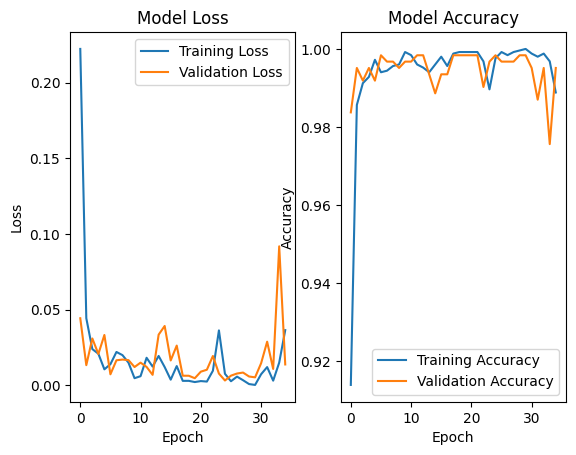

25/25 [==============================] - 3s 71ms/step


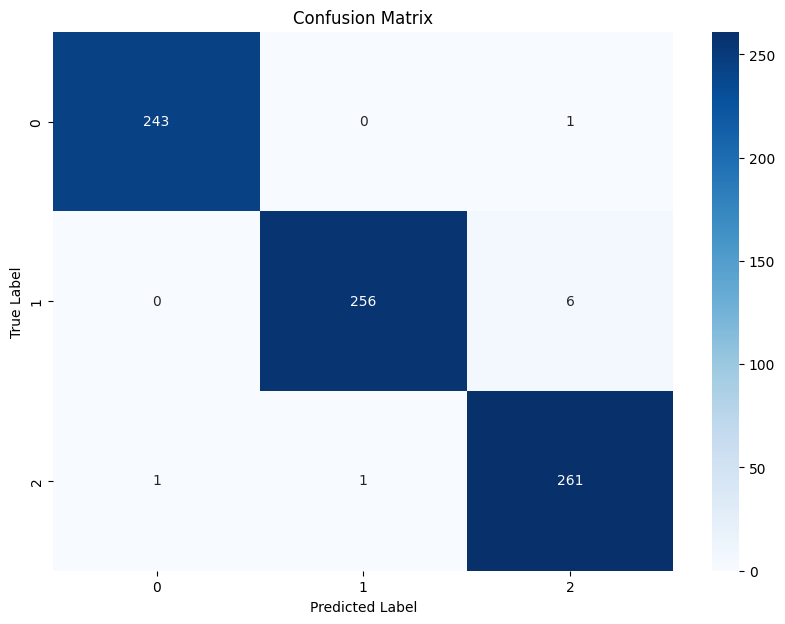

**********REPORT FOR  INCEPTIONV3  MODEL********** /n
25/25 [==============================] - 2s 72ms/step
              precision    recall  f1-score   support

       eagle       1.00      1.00      1.00       244
       panda       1.00      0.98      0.99       262
  polar-bear       0.97      0.99      0.98       263

    accuracy                           0.99       769
   macro avg       0.99      0.99      0.99       769
weighted avg       0.99      0.99      0.99       769

******************************************


In [ ]:
import argparse
import numpy as np
import pandas as pd
import cv2
import os
import tensorflow as tf
from tensorflow import keras
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.python.keras import layers, Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.python.keras.models import load_model, Model
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt


base_model = keras.applications.InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3),
    )
base_model.summary()


x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
predictions = keras.layers.Dense(3, activation='softmax')(x)


inception_model = keras.models.Model(inputs=base_model.input, outputs=predictions)

inception_model.summary()
inception_model.compile(
optimizer=keras.optimizers.Adam(learning_rate= 0.0001),
loss='sparse_categorical_crossentropy',
metrics=['accuracy']
)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = inception_model.fit(train_set, epochs=50, validation_data=val_set, callbacks=[stop_early])
inception_model.save('inception_model.h5')

# Evaluacija modela
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
test_set = test_datagen.flow(test_imgs, test_labels, batch_size=32, shuffle=False)
test_loss, test_accuracy = inception_model.evaluate(test_set)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

#Prikaz rezultata
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


#Confusion matrica
test_predictions = inception_model.predict(test_imgs)
test_predictions = np.argmax(test_predictions, axis=1)  # Convert probabilities to class labels

conf_matrix = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

report_model(inception_model, "inceptionv3", test_imgs, test_labels, class_map)